ESTO ES PARA EL LST

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon
from matplotlib.tri import Triangulation
from LST import LST
from Node import Node
from solve import Pro_Solver
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace


In [45]:
input_file = "T4.geo"
output_file = "mallas/malla_LST.msh"  
titulo = "Caso LST"

In [46]:
def reorder_triangle6(node_ids, nodes):
    def coord(nid): return np.array([nodes[nid - 1].x, nodes[nid - 1].y])
    pts = [coord(nid) for nid in node_ids]

    centroide = sum(pts) / 6
    distancias = [np.linalg.norm(p - centroide) for p in pts]
    esquinas = sorted(range(6), key=lambda i: -distancias[i])[:3]
    medios = [i for i in range(6) if i not in esquinas]

    esquina_coords = [pts[i] for i in esquinas]
    centro = np.mean(esquina_coords, axis=0)
    angulos = [np.arctan2(p[1] - centro[1], p[0] - centro[0]) for p in esquina_coords]
    orden = [x for _, x in sorted(zip(angulos, esquinas))]

    n1, n2, n3 = [node_ids[i] for i in orden]

    def mid_of(a, b):
        return (coord(a) + coord(b)) / 2

    m12 = min(medios, key=lambda i: np.linalg.norm(coord(node_ids[i]) - mid_of(n1, n2)))
    m23 = min([i for i in medios if i != m12], key=lambda i: np.linalg.norm(coord(node_ids[i]) - mid_of(n2, n3)))
    m31 = [i for i in medios if i != m12 and i != m23][0]

    return [n1, n2, n3, node_ids[m12], node_ids[m23], node_ids[m31]]


In [47]:
from LST import LST
from Node import Node
# 👇 AQUI MISMO pega esta función:

def fix_LST_order(node_ids, nodes):
    """
    Corrige el orden de los nodos de un triángulo LST para asegurar sentido antihorario.
    Muestra advertencia si se aplica corrección.
    """
    p1 = np.array([nodes[node_ids[0] - 1].x, nodes[node_ids[0] - 1].y])
    p2 = np.array([nodes[node_ids[1] - 1].x, nodes[node_ids[1] - 1].y])
    p3 = np.array([nodes[node_ids[2] - 1].x, nodes[node_ids[2] - 1].y])
    detJ = 0.5 * ((p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1]))

    if detJ <= 0:
        print(f"⚠️ Elemento con nodos {node_ids} tiene det(J) = {detJ:.4e} (corrigiendo orden)")
        return [node_ids[0], node_ids[2], node_ids[1], node_ids[5], node_ids[4], node_ids[3]]
    return node_ids



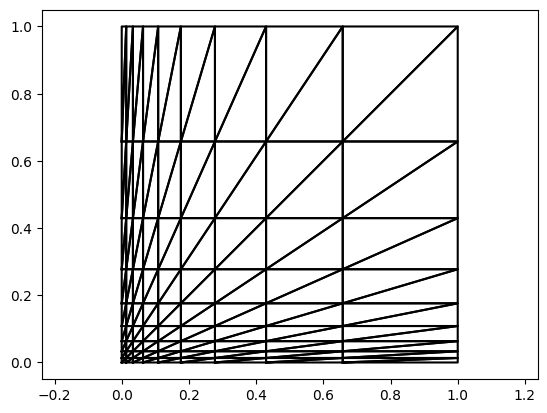

In [48]:
mesh = meshio.read(output_file)
nodes = [Node(i + 1, x, y) for i, (x, y, _) in enumerate(mesh.points)]

lst_elements = []
for cell_block in mesh.cells:
    if cell_block.type == "triangle6":
        for i, node_ids in enumerate(cell_block.data):
            node_ids = [int(id) + 1 for id in node_ids]  # pasar a base 1
            ordered_ids = reorder_triangle6(node_ids, nodes)
            lst_elements.append(LST(i + 1, ordered_ids))

        break

boundary_nodes = {1: set(), 2: set(), 3: set(), 4: set()}
if "line3" in mesh.cell_data_dict["gmsh:physical"]:
    for cell_block in mesh.cells:
        if cell_block.type == "line3":
            physical_ids = mesh.cell_data_dict["gmsh:physical"]["line3"]
            for line, phys_id in zip(cell_block.data, physical_ids):
                if phys_id in boundary_nodes:
                    for node_id in line:
                        boundary_nodes[phys_id].add(int(node_id) + 1)

for node in nodes:
    node.boundary_label = []
    for label_id, node_set in boundary_nodes.items():
        if node.id in node_set:
            node.boundary_label.append("Dirichlet Boundary")

# Verificación visual
for elem in lst_elements:
    coords = np.array([[nodes[i - 1].x, nodes[i - 1].y] for i in elem.node_ids])
    x, y = coords[:, 0], coords[:, 1]
    plt.plot(np.append(x[:3], x[0]), np.append(y[:3], y[0]), 'k-')
plt.axis("equal")
plt.show()

In [49]:
alpha = 3
for node in nodes:
    node.solve_u(alpha)


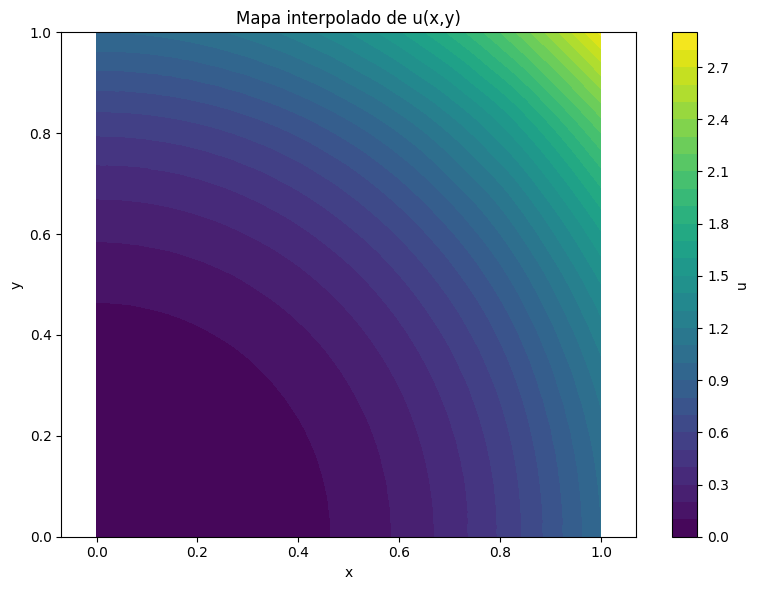

In [50]:
from scipy.interpolate import griddata
def plot_u_field(nodes, elements, use_attr="u", mode="colormap"):
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    z = np.array([getattr(node, use_attr) for node in nodes])
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    if mode == "colormap":
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((x, y), z, (X, Y), method='cubic')
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=30, cmap='viridis')
        plt.colorbar(label=use_attr)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Mapa interpolado de {use_attr}(x,y)")
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig(f"LST_{use_attr}_{mode}_plot.png", dpi=300)
        plt.show()

plot_u_field(nodes, lst_elements, use_attr="u", mode="colormap")

In [51]:
# Verificación nodos libres y Dirichlet
free_nodes = [node.id for node in nodes if not node.boundary_label]
print(f"Nodos libres: {len(free_nodes)} → {free_nodes}")

dirichlet_nodes = []
for node in nodes:
    if hasattr(node, "boundary_label") and any("Dirichlet" in label for label in node.boundary_label):
        dirichlet_nodes.append((node.id, node.x, node.y, node.u))
print(f"🧱 Total Dirichlet nodes: {len(dirichlet_nodes)}")
for nid, x, y, u in dirichlet_nodes:
    print(f"Nodo {nid} → ({x:.3f}, {y:.3f}) → u = {u}")


Nodos libres: 289 → [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 2

⚠️ Elemento 149 tiene Jacobiano singular o negativo (det = -2.97e-05)
⚠️ Elemento 149 tiene matriz de rigidez nula
⚠️ Elemento 151 tiene Jacobiano singular o negativo (det = -1.63e-04)
⚠️ Elemento 151 tiene matriz de rigidez nula
⚠️ Elemento 153 tiene Jacobiano singular o negativo (det = -3.64e-04)
⚠️ Elemento 153 tiene matriz de rigidez nula
⚠️ Elemento 155 tiene Jacobiano singular o negativo (det = -6.65e-04)
⚠️ Elemento 155 tiene matriz de rigidez nula
⚠️ Elemento 157 tiene Jacobiano singular o negativo (det = -1.12e-03)
⚠️ Elemento 157 tiene matriz de rigidez nula
⚠️ Elemento 159 tiene Jacobiano singular o negativo (det = -1.79e-03)
⚠️ Elemento 159 tiene matriz de rigidez nula
⚠️ Elemento 161 tiene Jacobiano singular o negativo (det = -2.81e-03)
⚠️ Elemento 161 tiene matriz de rigidez nula
🔍 Tamaño sistema libre: (289, 289)
📐 Rango matriz libre: 289
🔁 Matriz simétrica: True


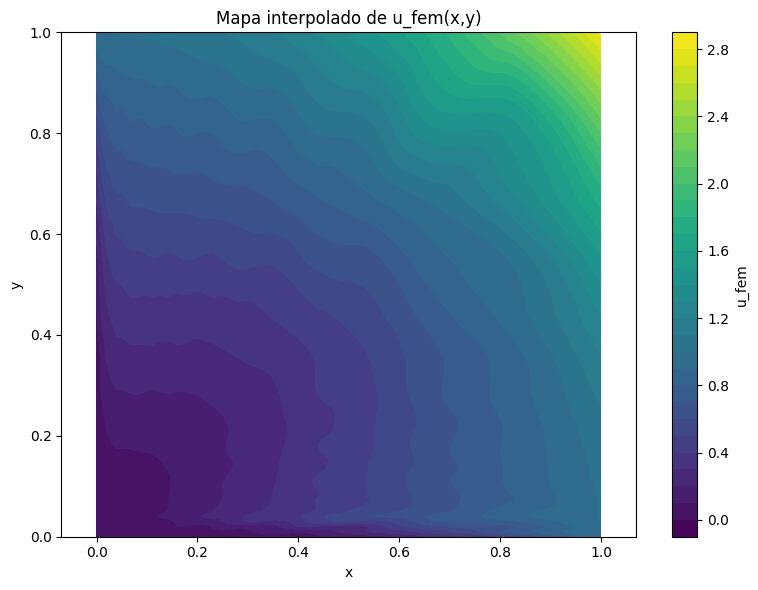

In [52]:
# Resolución FEM
Estructure = Pro_Solver(nodes, lst_elements, alpha)
Estructure.solve_system()

# Gráfico FEM
plot_u_field(nodes, lst_elements, use_attr="u_fem", mode="colormap")

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation
from scipy.interpolate import griddata

def plot_relative_error(nodes, elements, mode="colormap"):
    """
    Visualiza el error relativo |u_fem - u| / |u| mediante:
    - 'colormap' → mapa de color interpolado en 2D
    """
    # Extraer datos de nodos
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])

    # Evitar división por cero
    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) / (np.abs(u_ref) + eps)

    # Conectividad de elementos
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    #tri = Triangulation(x, y, triangles)

    if mode == "colormap":
        # Interpolación sobre malla regular
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((x, y), error_rel, (X, Y), method='cubic')

        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=30, cmap='plasma')
        plt.colorbar(label="Error relativo")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Error relativo |u_fem - u| / |u|")
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig("CST_relative_error_colormap.png", dpi=300)
        plt.show()

    else:
        raise ValueError("Modo no válido. Usa 'colormap'.")

    # Imprimir resumen numérico
    print(f"Máximo error relativo: {np.max(error_rel):.2e}")
    print(f"Promedio error relativo: {np.mean(error_rel):.2e}")
    print(f"Mínimo error relativo: {np.min(error_rel):.2e}")

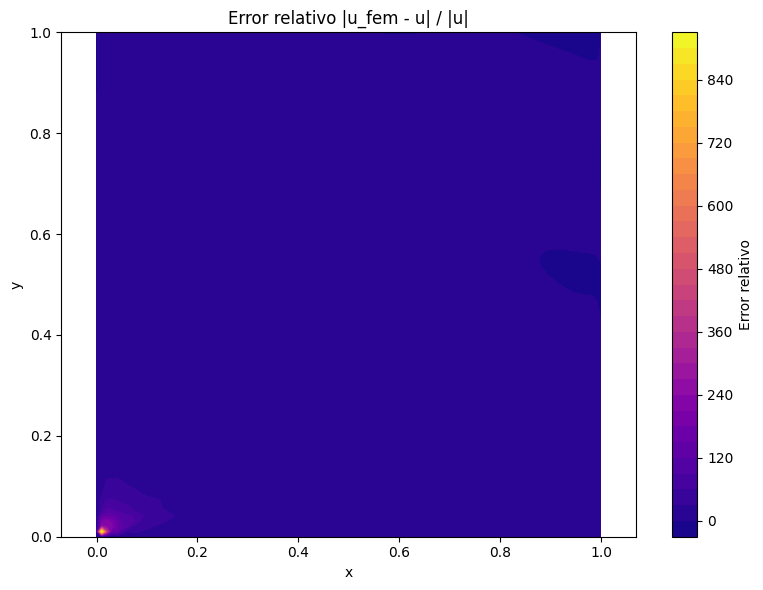

Máximo error relativo: 1.12e+03
Promedio error relativo: 2.41e+01
Mínimo error relativo: 0.00e+00


In [54]:
# Visualizar el error relativo
plot_relative_error(nodes, lst_elements, mode="colormap")